# Introduction

This notebook was prepared as an extension of a computational assignment for ECON 23200 Topics in Macroeconomics at UChicago. The goal was to numerically solve the standard neoclassical growth using value function iteration, and several improvement algorithms that perform the value function iteration quicker than a "brute force" algorithm. 

Recall that in this setup preferences are given by 
$$
\sum_{t=0}^{\infty} \beta^{t} \ln c_{t}
$$
subject to $c_{t} + k_{t+1} = zk_{t}^{\alpha} + (1-\delta)k_{t}$ where $c_t, k_t$ refer to consumption and capital at time $t$, respectively. 

In what follows, we will numerically solve for the optimal consumption and capital paths by first formulating this problem as a Bellman equation and then solving the Bellman equation using Value Function Iteration. The parameters we will use are $\beta = 0.98$, $\alpha = \frac{1}{3}$, $\delta = 1$, $z = 1$. 

# A. Theoretical Benchmark



1.  The Bellman equation is 
$$
V(k) = \max_{k' \in [0, zk^{\alpha}]} (\ln(zk^{\alpha} - k') + \beta V(k'))
$$
Or, plugging in the given parameters, 

$$
V(k) = \max_{k' \in [0, k^{\frac{1}{3}}]} (\ln(k^{\frac{1}{3}} - k') + 0.98 V(k'))
$$





4. We want to analytically solve the model first to compare with our numerical solution. Guess and Verify: We guess the value function $V(k) = a \log(k) + b$. Through some algebra, we will obtain

$$
\boxed{g(k) = (\frac{1}{3} \beta) k^{\frac{1}{3}} = 0.32 k^{\frac{1}{3}}}
$$
And the value function is 
$$
\boxed{V(k) = 0.49 \ln(k) - 46.9}
$$
Note that in order to solve for optimal consumption and capital paths using Bellman equations, it is necessary to solve for the value function and the optimal policy functions for consumption and capital, which is what we have analytically done here. Below, we begin numerically solving for these. 

In [9]:
#imports 
import numpy as np 
import time 
import matplotlib.pyplot as plt  

Before we move to the value function iterations, let's set up some things below. In particular we first need to discretize the state space, set parameter values, and define our utility function. 

In [10]:
#parameter values
z = 1 
delta = 1 
alpha = 1/3 
beta = 0.98 
epsilon = 1e-5 #tolerance level 
kss = 0.186 #Steady state capital as computed above
n = 200 

#Discretizing the state space: 
start = 0.05 
stop = 1.2 
d_state_space = np.linspace(start, stop, n)
for i in range(len(d_state_space)): 
    d_state_space[i] = d_state_space[i]*kss
#The object d_state_space is now the vector (0.05kss,....,1.2kss) with n = 200 

#Utility function 
utility = lambda c: np.log(c) 

# B. Brute Force Value Function Iteration

At each step, we will have an $n \times 1$ matrix (or $n$-dimensional vector) with our current values $v(k_{i})$ for $1 \leq i \leq n = 200$. We begin with $V^{(0)}(k) = \{V^{(0)}_{1}, V^{(0)}_{2}, \dots, V^{(0)}_{200}\} = (0, \dots, 0)$. The initial guess doesn't matter since the CMT ensures convergence (and so we will always get as close as we desire, eventually). 

**Answers to questions**: The program takes $64.5$ seconds to run. The code and the plots for $V$ and the $c$ and $k'$ policy functions are provided below. We note that the results agree with what we found in A.: All three are strictly increasing in $k$. Furthermore, 

In [120]:
#Initializing 
start_time = time.time()


v_guess = np.zeros(n) #initial guess for value function
error = 1 #initial margin of error -- will stop loop when this is less than epsilon
counter = 0 #counting the number of iterations 
max_iter = 1000 #maximum number of iterations 

#Iterating
v = v_guess #setting v to our initial guess 
while counter <= max_iter and error > epsilon: 
    counter = counter + 1 
    prev_v = v #vector v from the previous iteration 
    v = np.zeros(n) #This is the v for next period, which we will update in the next two loops 
    g = np.zeros(n) #Policy vector 
    k_prime = np.zeros(n) #how much capital is carried over to the next period 
    consumption = np.zeros(n) #consumption 
    trial = np.zeros(n)
    
    #looping over state space for current capital
    for i in range(len(d_state_space)): 
        prev_k = d_state_space[i]
        choices = np.zeros(n) #an array of zeros, which will store the potential choices for k' given k
        
        #looping over state space for future capital choice 
        for j in range(n): 
            c = prev_k**alpha - d_state_space[j]
            t = 0 
            if c > 0: 
                t = utility(c) + beta*prev_v[j] 
            else: 
                t = -99 
            choices[j] = t 
            
        #At this point, the j loop is finished, and we have constructed choices (given i); now we find max of choices
        #In particular, we need to find the maximum of 'choices' and its index 
        max_v = np.amax(choices) #the maximum value of the vector 'choices' 
        max_policy = np.where(choices == max_v)[0][0] #returns the j for which choices is maximum 
        v[i] = max_v #updating value vector
        g[i] = max_policy #updating policy vector
        k_prime[i] = d_state_space[int(g[i])]
        consumption[i] = (d_state_space[i]**alpha)-(d_state_space[int(g[i])])
        

    #Now, the i loop is finished, and we have updated the value vector for the next iteration
    #We also have the policy vector g
    error = np.amax(abs(v-prev_v)) 

print("It took", time.time() - start_time, "seconds to run this")
    




It took 64.54055500030518 seconds to run this


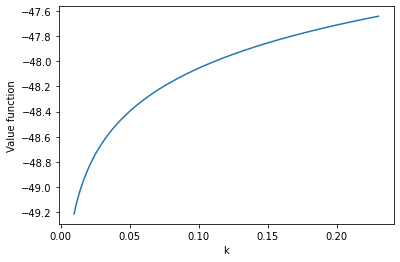

In [125]:
#Plots

#Value function 
plt.plot(d_state_space, v)
plt.xlabel("k")
plt.ylabel("Value function")
plt.show()

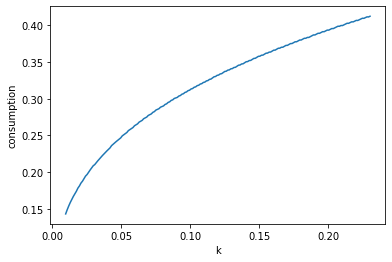

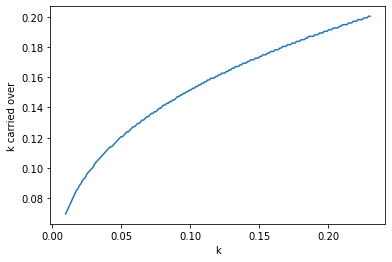

In [124]:
#Policy functions 
plt.plot(d_state_space, consumption) 
plt.xlabel("k")
plt.ylabel("consumption")
plt.show()


plt.plot(d_state_space, k_prime)
plt.xlabel("k")
plt.ylabel("k carried over")
plt.show()

# C. An Improved Initial Guess 

Rather than guessing $V^{(0)} = (0, \dots, 0)$ now, we will guess
$$
V^{(0)} = \left\{\frac{u(f(k_{i}) - \delta k_{i})}{1 - \beta}\right\}_{i=1}^{n}
$$
The economic intuition of this guess is that $V$ is now being set to be the presented discounted value of the steady state level of consumption. This means that for any $k_{i}$, the $k_{j}$ chosen (i.e. the capital carried over to the next period) will be close to $k_{i}$ (as opposed to the random guess in A), and so convergence will be faster. Indeed, this is what we see, since convergence happens in $7$ iterations here, as opposed to over $500$ in A. 

As seen below, the value function iteration with this improved initial guess converges in $0.87$ seconds! This is a drastic improvement from the $64.5$ seconds it took A. to converge (since we're already starting close to limit value function). 

In [11]:
#Time 
start_time = time.time()

#Constructing v_guess
guess_func = lambda k: (utility(z*(k**alpha) -  delta*k))/(1-beta)
v_guess = guess_func(d_state_space)

#Initializing 
v = v_guess
error = 1 
counter = 0 
max_iter = 1000 

#Running loops -- code remains exactly the same as before 
while counter <= max_iter and error > epsilon: 
    counter = counter + 1 
    prev_v = v 
    v = np.zeros(n) 
    g = np.zeros(n) 
    
    #looping over state space for current capital
    for i in range(len(d_state_space)): 
        prev_k = d_state_space[i]
        choices = np.zeros(n) 
        
        #looping over state space for future capital choice 
        for j in range(n): 
            c = prev_k**alpha - d_state_space[j]
            t = 0 
            if c > 0: 
                t = utility(c) + beta*prev_v[j] 
            else: 
                t = -99 
            choices[j] = t 
            
        
        max_v = np.amax(choices) 
        max_policy = np.where(choices == max_v)[0][0] 
        v[i] = max_v 
        g[i] = max_policy 

    
    error = np.amax(abs(v-prev_v)) 

print("This took", time.time() - start_time, "to run")

This took 0.8778822422027588 to run


7

# D. Improved Decision Process

We will now speed up convergence -- compared to A -- by exploiting the fact that the policy rule $g$ is strictly increasing in $k_{i}$. For each i, the set the j roop runs over can be made smaller to make the code implement faster.

As noted, A. took $64.5$ seconds to run. As seen below, the program below -- with the improved decision process -- only took $26.3$ seconds to run, so we have more the halved the time. The result coincide with those obtained in part A. 

In [126]:
#Time 
start_time = time.time()


#Initializing
v_guess = np.zeros(n)
g_guess = np.zeros(n)
v = v_guess
g = g_guess
error = 1 
counter = 0 
max_iter = 1000 

#Running loops -- notice changes below 
while counter <= max_iter and error > epsilon: 
    counter = counter + 1 
    prev_v = v 
    prev_g = g
    v = np.zeros(n) 
    g = np.zeros(n) 
    
    #Let's deal with the i == 0 case first 
    prev_k = d_state_space[0] 
    choices = np.zeros(n)
    for j in range(n): 
        c = prev_k**alpha - d_state_space[j]
        t = 0 
        if c > 0: 
            t = utility(c) + beta*prev_v[j] 
        else: 
            t = -99 
        choices[j] = t 
    
    max_v = np.amax(choices) 
    max_policy = np.where(choices == max_v)[0][0] 
    v[0] = max_v 
    g[0] = max_policy     
        
        
        
    #looping over state space for current capital, for i \geq 1 
    for i in range(1,n): 
        prev_k = d_state_space[i]
        choices = np.zeros(n - int(prev_g[i-1])) 
        for j in range(int(prev_g[i-1]), n): #Note the change here from before, we start at g[i-1] and not 0 
            c = prev_k**alpha - d_state_space[j]
            t = 0 
            if c > 0: 
                t = utility(c) + beta*prev_v[j] 
            else: 
                t = -99 
            choices[j-int(prev_g[i-1])] = t 
        
        max_v = np.amax(choices) 
        max_policy = np.where(choices == max_v)[0][0] + prev_g[i-1]
        v[i] = max_v 
        g[i] = max_policy 

    
    error = np.amax(abs(v-prev_v))

print("This took", time.time() - start_time, "seconds to run")

This took 26.276169061660767 seconds to run


# E. Storing the Return Function

Rather than extensively doing everything in the loop, we can also do this using some linear algebra/matrix operations. The return_function matrix is key to this. The $(i,j)$ entry in this matrix is the value of having capital level $i$ today and capital level $j$ tomorrow. 

Convergence takes $0.07$ seconds. The resultant value function coincides with that obtained in A. 

In [130]:
#Time 
start_time = time.time()

#Setting initial values
error = 1 
counter = 0 
max_iter = 1000 
v_guess = np.zeros(n)


#Constructing matrices, as described above. 'return_function' is the matrix of interest; s_today and s_tomorrow are intermediate
s_today = np.tile(z*(d_state_space**alpha), (n, 1)) #Row i is identically z(k_i^alpha)
s_tomorrow = np.tile(d_state_space, (n,1)).transpose() #row j is identically k_j
return_function = s_today - s_tomorrow
return_function[return_function < 0] = np.exp(-99) #Just to ensure that we are able to take the log of this matrix, and that negative values are assigned -99
return_function = utility(return_function)


#Now we have constructed the matrix return_function and can run the VFI 
v = v_guess
while counter <= max_iter and error > epsilon: 
    counter = counter + 1 
    prev_v = v 
    prev_v_matrix = np.tile(prev_v, (n,1))
    v = np.zeros(n)
    return_value = np.zeros((n,n))
    return_value = return_function + beta*prev_v_matrix 
    v = np.amax(return_value, 1) #maximum value for each row is stored in the array v 
    error = np.amax(abs(v-prev_v))

print("This took", time.time() - start_time, "seconds to run")

This took 0.07885313034057617 seconds to run


# F. Howard's Algorithm 

Now we improve upon D. even further by using Howards improvement alogirthm. This uses the fact that maximization is the most time-consuming part of the algorithm and thus minimizes the number of maximizations. In each iteration of updating the value function (maximizing), the policy function is updated several times using the same value function. This reduces the number of maximizations needed to reach convergence and speeds up the process. Convergence takes $3.7$ seconds. 

In [131]:
#Time 
start_time = time.time()

#Initializing
v_guess = np.zeros(n)
g_guess = np.zeros(n)
v = v_guess
g = g_guess
error = 1 
counter = 0 
max_iter = 1000 

#Running loops -- notice changes below 
while counter <= max_iter and error > epsilon: 
    counter = counter + 1 
    prev_v = v 
    prev_g = g
    v = np.zeros(n) 
    g = np.zeros(n) 
    
    #Let's deal with the i == 0 case first 
    prev_k = d_state_space[0] 
    choices = np.zeros(n)
    for j in range(n): 
        c = prev_k**alpha - d_state_space[j]
        t = 0 
        if c > 0: 
            t = utility(c) + beta*prev_v[j] 
        else: 
            t = -99 
        choices[j] = t 
    
    max_v = np.amax(choices) 
    max_policy = np.where(choices == max_v)[0][0] 
    v[0] = max_v 
    g[0] = max_policy     
        
        
        
    #looping over state space for current capital, for i \geq 1 
    for i in range(1,n): 
        prev_k = d_state_space[i]
        choices = np.zeros(n - int(prev_g[i-1])) 
        for j in range(int(prev_g[i-1]), n): #Note the change here from before, we start at g[i-1] and not 0 
            c = prev_k**alpha - d_state_space[j]
            t = 0 
            if c > 0: 
                t = utility(c) + beta*prev_v[j] 
            else: 
                t = -99 
            choices[j-int(prev_g[i-1])] = t 
        
        max_v = np.amax(choices) 
        max_policy = np.where(choices == max_v)[0][0] + prev_g[i-1]
        v[i] = max_v 
        g[i] = max_policy 

    #Howard's improvement: updating the value function a few more times before iterating again 
    counter_h = 0
    n_h = 100
    while counter_h < n_h: 
        counter_h = counter_h + 1
        v_0 = v #v_0 as in problem set
        v_1 = np.zeros(n) 
        for i in range(n): 
            c = z*(d_state_space[i]**alpha) - d_state_space[int(g[i])]
            if c > 0:
                v_1[i] = utility(c)+beta*v_0[int(g[i])] #This is the function we will update from
            else: 
                v_1[i] = -99
        v = v_1 #v_1 and v_0 are just intermediate arrays used in the updating process; v is what we're interested in 
    
    error = np.amax(abs(v-prev_v)) #After the "Howard loop" is finished, we continue with the regular loop
    
print("This took", time.time()-start_time, "seconds to run")

This took 3.6847901344299316 seconds to run


# G. Combining Methods E and F

In this case, we want to add Howard's imrovement to the matrix method presented in part E. 

In [2]:
#Time 
start_time = time.time()


#Setting initial values
error = 1 
counter = 0 
max_iter = 1000 
v_guess = np.zeros(n)


#Constructing matrices, as described above. 'return_function' is the matrix of interest; s_today and s_tomorrow are intermediate
s_today = np.tile(z*(d_state_space**alpha), (n, 1)) #Row i is identically z(k_i^alpha)
s_tomorrow = np.tile(d_state_space, (n,1)).transpose() #row j is identically k_j
return_function = s_today - s_tomorrow
return_function[return_function < 0] = np.exp(-99) #Just to ensure that we are able to take the log of this matrix, and that negative values are assigned -99
return_function = utility(return_function)


#Now we have constructed the matrix return_function and can run the VFI 
v = v_guess
while counter <= max_iter and error > epsilon: 
    counter = counter + 1 
    prev_v = v 
    prev_v_matrix = np.tile(prev_v, (n,1))
    v = np.zeros(n)
    return_value = np.zeros((n,n))
    return_value = return_function + beta*prev_v_matrix 
    v = np.amax(return_value, 1) #maximum value for each row is stored in the array v 
    g = np.argmax(return_value, 1) #policy vector
    
     #Howard's improvement 
    counter_h = 0
    n_h = 100
    while counter_h < n_h: 
        counter_h = counter_h + 1
        v_0 = v 
        v_1 = np.zeros(n) 
        for i in range(n): 
            c = z*(d_state_space[i]**alpha) - d_state_space[int(g[i])]
            if c > 0:
                v_1[i] = utility(c)+beta*v_0[int(g[i])] #This is the function we will update from
            else: 
                v_1[i] = v_0[i]
        v = v_1
    
    
    
    
    error = np.amax(abs(v-prev_v))

print("This took", time.time() - start_time, "seconds to run")



    

NameError: name 'time' is not defined

**Unnecessary calculations avoided**: In each step, we avoided several unnecessary calculations. In. 

The computational time for each algorithm is below: 
1. **Brute Force VFI**: 64.5 seconds
2. **Improved Initial Guess**: 0.87 seconds 
3. **Improved Decision Process**: 26.27 seconds
4. **Storing the return function**: 0.07 seconds
5. **Howard's Improvement**: 3.68 seconds 
6. **Howard's Improvement + Storing the return function**: 0.68 seconds